In [130]:
# Load dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pymongo import MongoClient
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.palettes import Category20c
from math import pi
import plotly.express as px

Import data:
mongoimport --type csv -d SpotifyDataset -c SpotifySongs --headerline --drop project_3_clean.csv

In [131]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

In [132]:
# confirm database was created
print(mongo.list_database_names())

['SpotifyDataset', 'admin', 'config']


In [133]:
# assign the database to a variable name
spotify_db = mongo['SpotifyDataset']

In [134]:
# review the collections in our new database
print(spotify_db.list_collection_names())

['SpotifySongs']


In [89]:
# review a document collection
print(spotify_db.SpotifySongs.find_one())

{'_id': ObjectId('6711b921c1425e20be8accee'), 'artist': 'blink-182', 'song': 'all the small things', 'duration_ms': 167066, 'explicit': 'False', 'year': 1999, 'popularity': 79, 'danceability': 44.51282051282051, 'energy': 89.7897897897898, 'key': 0, 'loudness': -4.918, 'mode': 1, 'speechiness': 8.472222222222223, 'acousticness': 1.1534154535274355, 'instrumentalness': 0.0, 'liveness': 71.74677608440797, 'valence': 70.29804727646454, 'tempo': 148.726, 'genre': 'rock', 'duration_minutes': 2.7844333333333333}


In [90]:
# assign the collection to a variable
songs = spotify_db['SpotifySongs']

In [91]:
# Display the number of documents 
songs.count_documents({})

1838

### Kimberly's Code: Top 10 Artists by Song Count & Top Artist's Song Popularity Percentages

In [92]:
#Aggregate by artist
artists = [
    { 
        "$group": {
            "_id": "$artist",  # Group by the artist field
            "count": {"$sum": 1}  # Count the number of occurrences of each artist
        }
    },
    { 
        "$sort": {"count": -1}  # Sort by count in descending order
    },
    { 
        "$limit": 10  # Limit the result to the top artist
    }
]
results = list(songs.aggregate(artists))

In [93]:
# Output the top 10 artists with their counts
print("Top 10 artists:")
top_artists = []
for i, artist in enumerate(results, start=1):
    print(f"{i}. {artist['_id']} with {artist['count']} songs.")
    top_artists.append(artist['_id'])  # Store top artist names

Top 10 artists:
1. rihanna with 22 songs.
2. eminem with 21 songs.
3. calvin harris with 20 songs.
4. drake with 19 songs.
5. david guetta with 18 songs.
6. britney spears with 18 songs.
7. chris brown with 16 songs.
8. taylor swift with 16 songs.
9. katy perry with 16 songs.
10. kanye west with 16 songs.


In [94]:
# Extract data for plotting
artist_names = [artist['_id'] for artist in results]
song_counts = [artist['count'] for artist in results]

In [95]:
# Create a DataFrame for the data
data = {
    'Artists': artist_names,
    'Number of Songs': song_counts
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create the bar plot using Plotly Express
top_artist_plot = px.bar(df, x= 'Artists', y= 'Number of Songs', 
             title='Top 10 Artists by Number of Songs',
             labels={'Artists': 'Artists', 'Number of Songs': 'Number of Songs'},
             color='Number of Songs',  # Color by the number of songs
             color_continuous_scale=px.colors.sequential.Greens,
             template='plotly_dark')  # Color scale

# Show the plot
top_artist_plot.update_layout(xaxis_tickangle=0)  
top_artist_plot.show()

In [96]:
# Save the interactive visualization as an HTML file
top_artist_plot.write_html('Top_10_Artists_by_Number_of_Songs.html')

In [155]:
# Step 1: Find the top 10 artists with the most songs
top_artists = list(songs.aggregate([
    {
        "$group": {
            "_id": "$artist",  # Group by artist
            "song_count": {"$sum": 1},  # Count the number of songs for each artist
            "average_popularity": {"$avg": "$popularity"}  # Calculate average popularity
        }
    },
    {
        "$sort": {"song_count": -1}  # Sort by song count in descending order
    },
    {
        "$limit": 10  # Limit to top 10 artists
    }
]))

# Step 2: Extract the artist names from the aggregation result
top_artist_names = [artist['_id'] for artist in top_artists]

# Step 3: Query to get all songs by the top 10 artists and keep necessary fields
all_songs_by_top_artists = list(songs.find(
    {"artist": {"$in": top_artist_names}},
    {"artist": 1, "song": 1, "popularity": 1}
).sort("artist", 1))

# Output all songs by the top 10 artists, ordered by artist
print("\nAll songs by the top 10 artists (ordered by artist):")
for i, song in enumerate(all_songs_by_top_artists, start=1):
    print(f"{i}. {song['artist']} - {song['song']} (Popularity: {song.get('popularity', 'N/A')})")


All songs by the top 10 artists (ordered by artist):
1. britney spears - oops!...i did it again (Popularity: 77)
2. britney spears - born to make you happy (Popularity: 58)
3. britney spears - lucky (Popularity: 65)
4. britney spears - i'm a slave 4 u (Popularity: 69)
5. britney spears - overprotected - radio edit (Popularity: 61)
6. britney spears - i'm not a girl, not yet a woman (Popularity: 58)
7. britney spears - me against the music (feat. madonna) - lp version / video mix (Popularity: 59)
8. britney spears - toxic (Popularity: 81)
9. britney spears - my prerogative (Popularity: 53)
10. britney spears - gimme more (Popularity: 79)
11. britney spears - break the ice (Popularity: 61)
12. britney spears - womanizer (Popularity: 76)
13. britney spears - piece of me (Popularity: 64)
14. britney spears - circus (Popularity: 74)
15. britney spears - if u seek amy (Popularity: 69)
16. britney spears - i wanna go (Popularity: 66)
17. britney spears - till the world ends (Popularity: 65)


In [158]:
# Step 4: Convert the list of songs to a DataFrame
all_songs_popularity_df = pd.DataFrame(all_songs_by_top_artists)

# Ensure the DataFrame has all required columns
if not all_songs_popularity_df.empty:
    all_songs_popularity_df = all_songs_popularity_df.rename(columns={
        'artist': 'Artist', 
        'popularity': 'Average Popularity'  # Rename to match what you're plotting
    })

    # Add 'Song Count' column for hover text
    artist_song_count = pd.Series(top_artist_names).value_counts()
    all_songs_popularity_df['Song Count'] = all_songs_popularity_df['Artist'].map(artist_song_count)
    all_songs_popularity_df['Hover Text'] = all_songs_popularity_df['Song Count'].astype(str) + " songs"

    # Step 5: Create the bubble chart
    all_songs_popularity = px.scatter(all_songs_popularity_df, x='Artist', y='Average Popularity', 
                     size='Average Popularity',  # Bubble size based on popularity
                     color='Average Popularity',  # Color by average popularity
                     hover_name='song',  # Show artist song name on hover
                     hover_data={'Song Count': True},  # Show song count in hover data
                     title='Top 10 Artists by Number of Songs and Average Popularity',
                     labels={'Average Popularity': 'Average Popularity (%)'},
                     color_continuous_scale=px.colors.sequential.Greens,
                     template='plotly_dark')  # Color scale

# Show the plot
all_songs_popularity.show()

In [159]:
# Save the interactive visualization as an HTML file
all_songs_popularity.write_html('Top_10_Artists_by_Number_of_Songs_and_Popularity.html')

### Dylan's Code: Comparing Danceability vs. Energy of the Top Artist's Songs

In [163]:
selected_artists = [
    "rihanna",  # Replace with actual artist names
    "eminem",
    "calvin harris",
    "drake",
    "britney spears",
    "david guetta",
    "taylor swift",
    "kanye west",
    "katy perry",
    "chris brown"
] 

In [164]:
results = list(songs.aggregate([
    {
        '$match': {
            'artist': {'$in': selected_artists}  # Match the selected artists
        }
    },
    {
        '$group': {
            '_id': '$artist',
            'average_danceability': {'$avg': '$danceability'},
            'average_energy': {'$avg': '$energy'}
        }
    }
]))

In [165]:
artists = [result['_id'] for result in results]
average_danceability = [result['average_danceability'] for result in results]
average_energy = [result['average_energy'] for result in results]

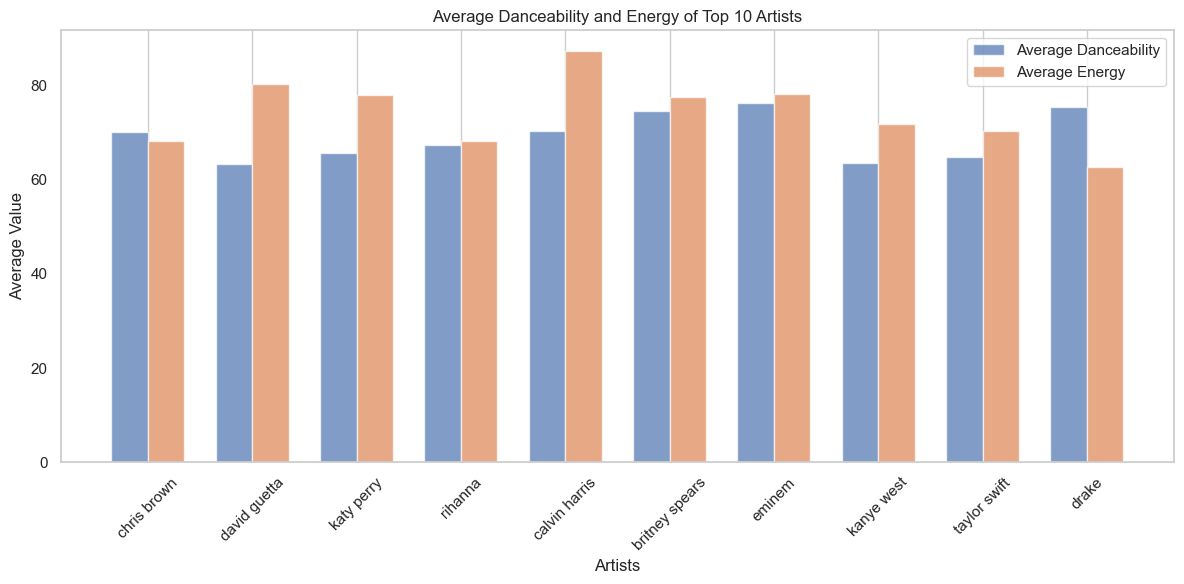

In [166]:
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(artists))

# Create bar charts for danceability and energy
plt.bar(index, average_danceability, bar_width, label='Average Danceability', alpha=0.7)
plt.bar([i + bar_width for i in index], average_energy, bar_width, label='Average Energy', alpha=0.7)

# Labels and title
plt.title('Average Danceability and Energy of Top 10 Artists')
plt.xlabel('Artists')
plt.ylabel('Average Value')
plt.xticks([i + bar_width / 2 for i in index], artists, rotation=45)
plt.legend()
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

In [226]:
from bokeh.plotting import output_notebook
output_notebook()
from bokeh.plotting import figure, output_file, save

Loading BokehJS ...

In [228]:
#Aggregate genre counts
genre_counts = list(songs.aggregate([
    {"$group": {"_id": "$genre", "count": {"$sum": 1}}},  # Group by genre and count
    {"$project": {"genre": "$_id", "count": 1}}  # Reshape the output
]))

In [229]:
#Convert DF 
genre_counts_df = pd.DataFrame(genre_counts)

In [230]:
#Prepare data for Bokeh
genre_counts_df['angle'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 2 * pi
genre_counts_df['color'] = Category20c[len(genre_counts_df)]

In [231]:
#Create the wedge plot
output_notebook()  
p = figure(outer_height=350, title="Song Genres Distribution", toolbar_location=None,
           tools="hover", tooltips="@genre: @count", x_range=(-0.5, 1.0))
p.wedge(x=0, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True),
         end_angle=cumsum('angle'), line_color="white", fill_color='color', legend_field='genre', 
         source=genre_counts_df)

# Add the circle
p.circle(x=0, y=1, radius=0.2, color="white")

# Adjust axis and grid visibility
p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

# Show the plot
show(p)

# Specify the output HTML file
output_file("Song_Genres_Distribution.html")

# Save the plot to the HTML file
save(p)

Loading BokehJS ...

'c:\\Users\\15073\\OneDrive\\Desktop\\Project-3\\Codes\\Song_Genres_Distribution.html'

In [234]:
genre_results = list(songs.aggregate([
    {"$match": {"artist": {"$in": selected_artists}}},  # Filter by selected artists
    {"$group": {"_id": "$genre"}}  # Group by genre
]))

# Step 2: Extract genres from the results
genres = [result['_id'] for result in genre_results]

# Print the list of genres
print("Genres of songs by selected artists:")
print(genres)

Genres of songs by selected artists:
['hip hop', 'pop']


In [235]:
genre_counts = list(songs.aggregate([
    {"$match": {"artist": {"$in": selected_artists}}},  # Filter by selected artists
    {"$group": {"_id": "$genre", "count": {"$sum": 1}}},  # Group by genre and count
    {"$project": {"genre": "$_id", "count": 1}}  # Reshape the output
]))

# Convert to DataFrame and calculate angles for pie chart
genre_counts_df = pd.DataFrame(genre_counts)
genre_counts_df['angle'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 2 * pi
colors = ['green', 'lightgreen'] * (len(genre_counts_df) // 2 + 1)  # Repeat until it covers all genres
genre_counts_df['color'] = colors[:len(genre_counts_df)]  # Ensure it matches the length


p = figure(outer_height=350, title="Genre Distribution of Selected Artists", toolbar_location=None, tools="hover", 
           tooltips="@genre: @count", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True),
         end_angle=cumsum('angle'), line_color="white", fill_color='color', legend_field='genre', 
         source=genre_counts_df)

# Add the circle
p.circle(x=0, y=1, radius=0.2, color="white")

# Adjust axis and grid visibility
p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

# Show the plot
show(p)

# Specify the output HTML file
output_file("Genre_Distribution_of_Selected_Artists.html")

# Save the plot to the HTML file
save(p)

'c:\\Users\\15073\\OneDrive\\Desktop\\Project-3\\Codes\\Genre_Distribution_of_Selected_Artists.html'

### Adolphus' Code: Song Popularity Trends by Year and 

In [178]:
# Step 1: Find the top 10 artists with the most songs
top_artists = list(songs.aggregate([
    {
        "$group": {
            "_id": "$artist",  # Group by artist
            "song_count": {"$sum": 1},  # Count the number of songs for each artist
            "average_popularity": {"$avg": "$popularity"}  # Calculate average popularity
        }
    },
    {
        "$sort": {"song_count": -1}  # Sort by song count in descending order
    },
    {
        "$limit": 10  # Limit to top 10 artists
    }
]))

# Step 2: Extract the artist names from the aggregation result
top_artist_names = [artist['_id'] for artist in top_artists]

# Step 3: Query to get all songs by the top 10 artists (without 'tempo')
all_songs_by_top_artists = list(songs.find(
    {"artist": {"$in": top_artist_names}},
    {"artist": 1, "song": 1, "popularity": 1}  # Only keep artist, song, and popularity fields
).sort("artist", 1))

# Output all songs by the top 10 artists, ordered by artist (without 'tempo')
print("\nAll songs by the top 10 artists (ordered by artist):")
for i, song in enumerate(all_songs_by_top_artists, start=1):
    print(f"{i}. {song['artist']} - {song['song']} (Popularity: {song.get('popularity', 'N/A')}%)")



All songs by the top 10 artists (ordered by artist):
1. britney spears - oops!...i did it again (Popularity: 77%)
2. britney spears - born to make you happy (Popularity: 58%)
3. britney spears - lucky (Popularity: 65%)
4. britney spears - i'm a slave 4 u (Popularity: 69%)
5. britney spears - overprotected - radio edit (Popularity: 61%)
6. britney spears - i'm not a girl, not yet a woman (Popularity: 58%)
7. britney spears - me against the music (feat. madonna) - lp version / video mix (Popularity: 59%)
8. britney spears - toxic (Popularity: 81%)
9. britney spears - my prerogative (Popularity: 53%)
10. britney spears - gimme more (Popularity: 79%)
11. britney spears - break the ice (Popularity: 61%)
12. britney spears - womanizer (Popularity: 76%)
13. britney spears - piece of me (Popularity: 64%)
14. britney spears - circus (Popularity: 74%)
15. britney spears - if u seek amy (Popularity: 69%)
16. britney spears - i wanna go (Popularity: 66%)
17. britney spears - till the world ends (

In [215]:
# Step 1: Query to get all songs by the top 10 artists, including release year and popularity
all_songs_by_top_artists = list(songs.find(
    {"artist": {"$in": top_artist_names}},
    {"artist": 1, "song": 1, "popularity": 1, "year": 1}  # Include release year and popularity for each song
))

# Step 2: Convert the results into a DataFrame
all_songs_popularity_by_year_df = pd.DataFrame(all_songs_by_top_artists)

# Rename the columns for clarity
all_songs_popularity_by_year_df = all_songs_popularity_by_year_df.rename(columns={
    'artist': 'Artist',
    'song': 'Song',
    'popularity': 'Popularity',
    'year': 'Year'
})

# Step 3: Group by Artist and Release Year and calculate average popularity per year
popularity_trend_by_artist_year_df = all_songs_popularity_by_year_df.groupby(
    ['Artist', 'Year']
).agg({
    'Popularity': 'mean'
}).reset_index()

# Step 4: Create a line graph using Plotly Express to show the popularity trend by year for top 10 artists
popularity_trend_by_artist_year = px.line(
    popularity_trend_by_artist_year_df, 
    x='Year', 
    y='Popularity', 
    color='Artist',  # Different colors for each artist
    title='Song Popularity Trends by Year for Top 10 Artists', 
    labels={'Release Year': 'Year', 'Popularity': 'Average Popularity (%)'},
    markers=True,
    color_discrete_sequence=px.colors.sequential.haline
)

# Show the plot
popularity_trend_by_artist_year.show()


In [217]:
# Aggregation pipeline to calculate the average tempo for each genre
genre_tempo = list(songs.aggregate([
    {
        "$group": {
            "_id": "$genre",  # Group by genre
            "average_tempo": { "$avg": "$tempo" }  # Calculate the average tempo for each genre
        }
    },
    {
        "$sort": { "average_tempo": -1 }  # Optionally sort by average tempo in descending order
    }
]))

# Output the average tempo for each genre
print("Average tempo for each genre:")
for genre in genre_tempo:
    print(f"{genre['_id']}: {genre['average_tempo']:.2f} BPM")


Average tempo for each genre:
easy listening: 157.92 BPM
rock: 126.09 BPM
country: 125.98 BPM
Dance/Electronic: 125.78 BPM
pop: 119.66 BPM
hip hop: 116.89 BPM
latin: 116.14 BPM
World/Traditional: 113.39 BPM
Folk/Acoustic: 111.66 BPM
metal: 109.61 BPM
R&B: 108.68 BPM


In [218]:
# Convert the result to a DataFrame
genre_tempo_df = pd.DataFrame(genre_tempo)

# Rename the columns for clarity
genre_tempo_df = genre_tempo_df.rename(columns={"_id": "Genre", "average_tempo": "Average Tempo"})

# Create the pie chart
genre_tempo = px.pie(genre_tempo_df, values='Average Tempo', names='Genre',
             title='Average Tempo Distribution by Genre',
             labels={'Average Tempo': 'Average Tempo (BPM)', 'Genre': 'Music Genre'},
             color_discrete_sequence=px.colors.sequential.haline)

# Percentages on graph = average tempo per genre

# Show the plot
genre_tempo.show()


### Sanjana's Code: Comparing Loudness vs. Valence in the Top and Bottom 10% of Songs

- loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


In [113]:
# Count the total number of songs
total_songs = songs.count_documents({})
total_songs

1838

In [114]:
# Calculate the number of songs to include in the top 10%
top_10_percent_count = int(total_songs * 0.1)
top_10_percent_count

183

In [144]:
# Query to sort songs by popularity in descending order and limit by top 10% count
top_10_percent_songs = list(
    songs.find({}, {"song": 1, "popularity": 1, "loudness": 1, "valence": 1, "artist": 1})  # Include loudness and valence
    .sort("popularity", -1)  # Sort by popularity in descending order
    .limit(top_10_percent_count)  # Limit the results to the top 10% of songs
)

# Output the top 10% songs
print("Top 10% of songs by popularity (ordered by popularity descending):")
for i, song in enumerate(top_10_percent_songs, start=1):
    print(f"{i}. {song['artist']} - {song['song']} - Popularity: {song['popularity']}%, Loudness: {song['loudness']} dB, Valence: {song['valence']}")


Top 10% of songs by popularity (ordered by popularity descending):
1. the neighbourhood - sweater weather - Popularity: 89%, Loudness: -2.81 dB, Valence: 40.904419321685516
2. tom odell - another love - Popularity: 88%, Loudness: -8.532 dB, Valence: 13.463514902363825
3. eminem - without me - Popularity: 87%, Loudness: -2.827 dB, Valence: 68.03699897225077
4. willow - wait a minute! - Popularity: 86%, Loudness: -5.279 dB, Valence: 69.06474820143885
5. eminem - the real slim shady - Popularity: 86%, Loudness: -4.244 dB, Valence: 78.10894141829394
6. ed sheeran - perfect - Popularity: 85%, Loudness: -6.312 dB, Valence: 17.26618705035971
7. eminem - 'till i collapse - Popularity: 85%, Loudness: -3.237 dB, Valence: 10.277492291880781
8. post malone - circles - Popularity: 85%, Loudness: -3.497 dB, Valence: 56.83453237410072
9. the neighbourhood - daddy issues - Popularity: 85%, Loudness: -9.461 dB, Valence: 34.635149023638235
10. bruno mars - locked out of heaven - Popularity: 85%, Loudnes

In [145]:
# Calculate the number of songs to include in the bottom 10%
bottom_10_percent_count = int(total_songs * 0.1)
bottom_10_percent_count

183

In [146]:
# Query to sort songs by popularity in ascending order and limit by bottom 10% count
bottom_10_percent_songs = list(
    songs.find({}, {"song": 1, "popularity": 1, "loudness": 1, "valence": 1, "artist": 1})  # Include loudness and valence
    .sort("popularity", 1)  # Sort by popularity in ascending order
    .limit(bottom_10_percent_count)  # Limit the results to the bottom 10% of songs
)

# Output the bottom 10% songs
print("Bottom 10% of songs by popularity (ordered by popularity ascending):")
for i, song in enumerate(bottom_10_percent_songs, start=1):
    print(f"{i}. {song['artist']} - {song['song']} - Popularity: {song['popularity']}%, Loudness: {song['loudness']} dB, Valence: {song['valence']}")


Bottom 10% of songs by popularity (ordered by popularity ascending):
1. p!nk - stupid girls - Popularity: 0%, Loudness: -5.045 dB, Valence: 58.17060637204522
2. schoolboy q - man of the year - Popularity: 0%, Loudness: -5.234 dB, Valence: 40.184994861253855
3. zedd - i want you to know - Popularity: 0%, Loudness: -2.215 dB, Valence: 38.54059609455293
4. years & years - king - Popularity: 0%, Loudness: -4.125 dB, Valence: 47.893114080164445
5. mariah carey - don't forget about us - radio edit - Popularity: 0%, Loudness: -6.816 dB, Valence: 39.67112024665982
6. lorde - team - Popularity: 0%, Loudness: -7.444 dB, Valence: 43.884892086330936
7. michel teló - ai se eu te pego - live - Popularity: 0%, Loudness: -4.55 dB, Valence: 87.35868448098664
8. shawn mendes - there's nothing holdin' me back - Popularity: 0%, Loudness: -4.035 dB, Valence: 99.28057553956835
9. astrid s - hurts so good - Popularity: 0%, Loudness: -5.008 dB, Valence: 38.951695786228164
10. maroon 5 - sugar - Popularity: 0%

In [147]:
# Convert the top 10% of songs to a DataFrame
top_songs_df = pd.DataFrame(top_10_percent_songs)

In [149]:
# Ensure that 'artist' and 'song' are strings before concatenation
top_songs_df['hover_text'] = top_songs_df['artist'].astype(str) + ' - ' + top_songs_df['song'].astype(str)

# Plot for Top 10% songs
fig_top = px.scatter(top_songs_df, x='loudness', y='valence', 
                     color='popularity', 
                     title="Top 10% Most Popular Songs: Loudness vs Valence",
                     labels={'loudness': 'Loudness (dB)', 'valence': 'Valence (Positivity)'},
                     hover_name='hover_text',  # Use the new hover text
                     size='popularity',
                     color_continuous_scale=px.colors.sequential.Greens,
                     template='plotly_dark')

# Show plot
fig_top.show()

In [150]:
# Convert the bottom 10% of songs to a DataFrame
bottom_songs_df = pd.DataFrame(bottom_10_percent_songs)

In [151]:
# Ensure that 'artist' and 'song' are strings before concatenation
bottom_songs_df['hover_text'] = bottom_songs_df['artist'].astype(str) + ' - ' + bottom_songs_df['song'].astype(str)

# Plot for Bottom 10% songs
fig_bottom = px.scatter(bottom_songs_df, x='loudness', y='valence', 
                     color='popularity', 
                     title="Bottom 10% Most Popular Songs: Loudness vs Valence",
                     labels={'loudness': 'Loudness (dB)', 'valence': 'Valence (Positivity)'},
                     hover_name='hover_text',  # Use the new hover text
                     size='popularity',
                     color_continuous_scale=px.colors.sequential.Greens,
                     template='plotly_dark')

# Show plot
fig_bottom.show()

In [152]:
# Save the interactive visualizations as HTML files
fig_top.write_html('top_10_percent_loudness_valence.html')
fig_bottom.write_html('bottom_10_percent_loudness_valence.html')